In [1]:
import struct
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Chunk:
    __header_size = 8;
    header = None
    data_position = -1
    fd = None
    def __init__(self,file):
        initial_pos = file.tell()
        self.header=file.read(self.__header_size)
        if not self.header:
            raise EOFError("EOF reached")
        if self.header[6]!=0x60 or self.header[7]!=0xc0:
            file.seek(initial_pos,0)
            raise LookupError("Chunk Header should end with 0x60c0")
        self.data_size = (self.header[1]*256 ) + self.header[0]
        self.nframe  = self.header[5]*0xff + self.header[4]
        self.type = self.header[3]
        self.data_position = file.tell()
        file.seek(self.data_size,1)
        self.fd=file
    
    def get_data(self):
        initial_pos = self.fd.tell()
        self.fd.seek(self.data_position,0)
        result = self.fd.read(self.data_size)
        self.fd.seek(initial_pos,0)
        return result
        

In [124]:
class VIPFile:
    fd = None
    filename = ""
    chunks = []
    initial_offset = 0x20
    def __init__(self,filename,initial_offset=0x20,max_chunks=-1):
        self.filename = filename
        self.fd = open(filename,"rb")
        self.initial_offset = initial_offset
        self.max_chunks=max_chunks
    
    def __del__(self):
        if self.fd:
            self.fd.close()
            
    def anal_vip_file(self):
        self.fd.seek(0,0)
        self.fd.seek(self.initial_offset,1)
        while True:
            try:
                tmp_chunk = Chunk(self.fd)
                self.chunks.append(tmp_chunk)
                if self.max_chunks>0 and self.max_chunks<len(self.chunks):
                    break
            except EOFError as e:
                break
            except Exception as e:
                print(e)
                raise e
            
    def show_info(self,init=0,end=-1,filter_by=[]):
        if end<0:
            end=len(self.chunks)
        for count,bh in  enumerate(self.chunks[init:end]):
            h=bh.header
            endset = "💩💩💩💩💩💩💩💩💩💩💩"
            size=bh.data_size
            
            text=""
            for i,b in enumerate(h):
                text+=f"{b:02x} " 
                if i==3:
                    if b==4:
                        endset = "🗝️"
                    elif b==7:
                        endset = "🎵"
                    elif b==2 :
                        endset = "🎨"
                    elif b==5:
                        endset = "🎬"
            if endset in filter_by or len(filter_by)==0:
                print(f"{count+init:06}: [{size:>6}]",end=" ")
                print(f"{text} {endset}")
            
    def show_info_acc(self,init=0,end=-1,filter_by=[]):
        res=[]
        if end<0:
            end=len(self.chunks)
        for count,bh in  enumerate(self.chunks[init:end]):
            h=bh.header
            size=bh.data_size
            
            text=""
            for i,b in enumerate(h):
                if i==3:
                    if b==5:
                        res.append(count+init)
        return res
            
    def pinta_paleta(self,id):
        paleta=self.get_paleta(id)
        #pintaremos
        colors = [x for x in range(len(paleta))]
        while len(colors)<256:
            colors.append(0)
        pal =  np.array( paleta ,dtype="uint8") 
        indices = np.array(colors)
        plt.imshow(pal[indices].reshape( (16,16,3) ) )
        
    def get_paleta(self,id):
        raw = self.chunks[id].get_data()
        paleta = []
        paleta.append((0,0,0))
        i=2
        while True:
            try:
                r,g,b = raw[i:i+3] # leemos RGB
                i+=3
                paleta.append( (r*4,g*4,b*4))
            except Exception as e:
                break
        return paleta
        
        
    
        

In [125]:
#f.seek(0x0DF5B6A0,0)
#f.seek(0x0135a684,0)

v =VIPFile("../data/game/iso/SN00002.VIP",0x0DF5B6A0,10000)

In [126]:
hex(0x0DF5B6A0  - 0x20)

'0xdf5b680'

In [127]:
v.anal_vip_file()

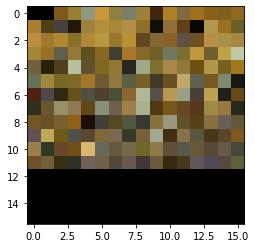

In [128]:
v.pinta_paleta(4742)

In [129]:
0xd670, 228*140

(54896, 31920)

In [130]:
l = [0x44, 0, 0x4,0 ]
hex(calcula_salto(l,0))



error: unpack requires a buffer of 2 bytes

In [130]:
0x85 & 0x7f

5

In [132]:
0x50

80

In [131]:
v.show_info_acc(0,20,["🎬"] )#,["🎨","🗝️"])

[4, 7, 10, 13, 16, 19]

In [19]:
0xe3 & 0x7f, 0xff& 0x7f

#0x80+0x64
0x3ff

1023

In [15]:
len(v.get_paleta(4742))

192

In [17]:
raw1 = v.chunks[184].get_data()

In [18]:
with open("puede_que_un_keyframe_184.frm","wb") as f:
    f.write(raw1)

In [17]:
 kdata = list(v.chunks[1].get_data())
list(zip(kdata[::2], kdata[1::2]))[:10]

[(255, 1),
 (227, 1),
 (255, 1),
 (227, 1),
 (255, 1),
 (227, 1),
 (255, 1),
 (227, 1),
 (255, 1),
 (227, 1)]

In [18]:
hex(0xc8a + (0x8c * 0xe4))

'0x893a'

In [132]:
def draw_kifrim(kifrim_id,paleta_id):
    res = []
    altoVideo = 0x8c
    anchoVideo = 0xe4
    pal = v.get_paleta(paleta_id)
    kdata = list(v.chunks[kifrim_id].get_data())
    for b in kdata:
        if b == 0:
            res += [255,0,0] * anchoVideo
            continue
        current_val = b
        nreps = (current_val & 0x7f ) +1
        col = [0,0,0]
        try:
             col=pal[next()]                
        except:
            pass
        res += col * nreps

            
    return np.array(res,dtype="uint").reshape(altoVideo,anchoVideo,3)
            
        

In [133]:
def calcula_salto(vaits, posicion_inicial_memoria=0xc8a):
    """Se supone que son 4 bytes.
    en el ejemplo viene como 0x00040044 y nos da un 
    salto a: 0x618a
    Nos llegaran como 44 00 04 00  hay que psarlo a LSB 0x00040044"""
    ax = struct.unpack("<H",bytearray(vaits))
    return posicion_inicial_memoria + ax[0]*228

In [258]:
def draw_difference(frame_anterior,diff_id,paleta_id):
    posicion_inicial=0
    siguiente_linea = 0xe4
    pal = v.get_paleta(paleta_id)
    kdata = list(v.chunks[diff_id].get_data())
    # nos saltamos los 2 primeros bytes
    pos=2
    nveces = kdata[pos]
    pos+=2
    salto=0
    while nveces != 0:
        salto+=calcula_salto(kdata[pos:pos+2],0)
        pos+=2
        num_lineas=kdata[pos]
        pos+=2
        while num_lineas != 0:
            num_commands = kdata[pos]
            pos+=1
            while num_commands != 0:
                salto_linea = kdata[pos]
                pos+=1
                type_dibujo = kdata[pos]
                pos+=1
                if type_dibujo<= 0x80:
                    #copiar los sigueintes n bytes
                    effective_pos = salto+salto_linea;
                    cuantas_veces = type_dibujo & 0x7f
                    cuantas_veces +=1
                    frame_anterior[effective_pos:effective_pos+cuantas_veces]=kdata[pos:pos+cuantas_veces]
                    pos+=cuantas_veces
                    effective_pos+=cuantas_veces
                else:
                    effective_pos = salto+salto_linea;
                    color = kdata[pos]
                    pos+=1
                    cuantas_veces = type_dibujo & 0x7f
                    cuantas_veces+=1
                    for i in range(cuantas_veces):
                        frame_anterior[effective_pos+i]=color
                    effective_pos+=cuantas_veces
                num_commands-=1
            num_lineas-=1
            salto+=siguiente_linea
        nveces-=1
    return frame_anterior
        
    

In [259]:



def draw_image_with_paleta(paleta,img,size):
    pal =  np.array( paleta ,dtype="uint8") 
    indices = np.array(img,dtype="uint8")
    plt.imshow(pal[indices].reshape( (size[0],size[1],3) ) )

In [260]:
frame_anterior = [0 for x in range(228*140)]

In [261]:
 v.show_info_acc(0,5,["🎬"] )

[4]

In [262]:
for i in v.show_info_acc(0,20,["🎬"] ):
    draw_difference(frame_anterior,i,0)


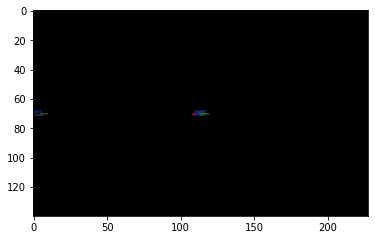

In [263]:
pal = v.get_paleta(0)
draw_image_with_paleta(pal,frame_anterior,(140,228))


In [264]:
a = [1,2,3]
b = [4,5]

In [86]:
a[1:3]=b[0:2]

In [87]:
a

[1, 4, 5]

In [ ]:
172800/3600

In [22]:
raw2 = []

for i,r in enumerate(list(raw1)):
    if i%2 == 0:
        raw2.append(0x0)
        continue
    if r>0xc0:
        raw2.append(0xFF)
    else:
        raw2.append(r)

In [23]:
with open("puede_que_un_keyframe_4743b.frm","wb") as f:
    f.write(np.array(raw2,dtype="uint8"))

In [25]:
pal =None 
with open("../data/game/iso/FILES/FINALPAL.PPS","rb") as fpal:
    data=fpal.read()
    pal = data[2:]
    
paleta = []
paleta.append( (0,0,0))
i=0
while True:
    try:
        r,g,b = pal[i:i+3] # leemos RGB
        i+=3
        paleta.append( (r*4,g*4,b*4))
    except Exception as e:
        break

In [26]:
raw =None 
with open("../data/game/iso/FILES/FINALPAN.PSP","rb") as fpal:
    data=fpal.read(4)
    w = data[1]*256+data[0]
    h = data[3]*256+data[2]
    raw=list(fpal.read(w*h))

ValueError: cannot reshape array of size 96315 into shape (140,228,3)

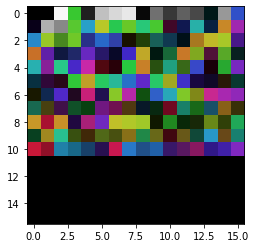

In [28]:
v.pinta_paleta(0)

In [29]:
v.show_info(0,30000,["🗝️"])

000001: [   560] 30 02 02 04 f0 d2 60 c0  🗝️
000645: [   560] 30 02 02 04 9c d4 60 c0  🗝️
001807: [   897] 81 03 02 04 a0 d7 60 c0  🗝️
003212: [  8049] 71 1f 02 04 48 db 60 c0  🗝️
004743: [ 41143] b7 a0 02 04 44 df 60 c0  🗝️


In [30]:
mypal = v.get_paleta(0)

In [31]:
raw=v.chunks[1].get_data()

In [32]:
hex(57),hex(35)
0x1ff,0x01e3

0x230/4

140.0

In [ ]:
rawpar = [ x for i,x in enumerate(list(raw)) if i%2==0]
len(rawpar)
rawpar[:10]

In [ ]:
sum(rawpar),228*140

In [ ]:
draw_image_with_paleta(mypal,list(rawpar),(3,10))


In [ ]:
raw = v.chunks[3212].get_data()

In [ ]:
with open("puede_que_un_keyframe_3212.frm","wb") as f:
    f.write(raw)

In [ ]:
raw2 = []

for r in list(raw):
    if r<200:
        raw2.append(0x11)
    else:
        raw2.append(r)

In [ ]:
with open("puede_que_un_keyframe_3b.frm","wb") as f:
    f.write(np.array(raw2,dtype="uint8"))

In [ ]:
len(raw2),len(raw)

In [ ]:
np.array(raw2)